Genetic algorithm – This is the most popular type of EA (Evolutionary algorithm)

In [1]:
import pandas as pd
import numpy as np
import random

from deap import base
from deap import creator
from deap import tools

In [2]:
prot_cal_p_gram = 4
carb_cal_p_gram = 4
fat_cal_p_gram = 9

total_calories_per_day = 2500
total_calories_per_week = total_calories_per_day*7
percentage_prot = 0.3
percentage_carb = 0.5
percentage_fat = 0.2

cal_prot = round(percentage_prot * total_calories_per_week)
cal_carb = round(percentage_carb * total_calories_per_week)
cal_fat = round(percentage_fat * total_calories_per_week)

In [3]:
#goal grams
gram_prot = cal_prot / prot_cal_p_gram
gram_carb = cal_carb / carb_cal_p_gram
gram_fat = cal_fat / fat_cal_p_gram

In [4]:
products = pd.read_csv("food.csv")

In [5]:
products

,Name,Units Min,Units Max,Calories,Gram_Prot,Gram_Fat,Gram_Carb
0,Banana,0,5,89,1.0,0.0,23.0
1,Mandarin,0,8,40,1.0,0.0,10.0
2,Apple,0,3,52,0.3,0.3,13.8
3,Chocolate,0,3,230,3.0,13.0,25.0
4,Olivier salad,0,10,580,24.0,44.0,19.0
5,Cutlet,0,10,108,18.0,1.3,6.0
6,Aspic,0,5,257,26.0,15.5,3.6
7,Champagne,0,10,88,0.0,0.0,1.7
8,Orange,0,8,43,0.9,0.2,8.1
9,Potatoes,0,10,91,3.4,1.8,14.6


In [6]:
cal_data = products[['Gram_Prot', 'Gram_Fat', 'Gram_Carb']]

prot_data = list(cal_data['Gram_Prot'])
fat_data = list(cal_data['Gram_Fat'])
carb_data = list(cal_data['Gram_Carb'])

In [7]:
def purchases():
    return random.choices( range(0, 22), k = len(products))

In [8]:
def cost(person):
    person = person[0]
    tot_prot = sum(x*y for x,y in zip(prot_data,person))
    tot_fat = sum(x*y for x,y in zip(fat_data,person))
    tot_carb = sum(x*y for x,y in zip(carb_data,person))
    u = prot_cal_p_gram * tot_prot + carb_cal_p_gram * tot_carb + fat_cal_p_gram * tot_fat
    
    return abs(u - total_calories_per_week), abs(tot_prot - gram_prot), abs(tot_fat - gram_fat), abs(tot_carb - gram_carb),

In [9]:
weights = (-1, -1/0.3, -5, -2)
creator.create("FitnessMin", base.Fitness, weights=weights)
creator.create("Person", list, fitness=creator.FitnessMin)

In [10]:
toolbox = base.Toolbox()

In [11]:
toolbox.register("purchases", purchases)
toolbox.register("person", tools.initRepeat, creator.Person, toolbox.purchases, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.person)

toolbox.register("cost", cost)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("cost", cost)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [12]:
toolbox.population(n=10)

[[[12, 2, 7, 0, 5, 2, 13, 14, 4, 14]],
 [[6, 3, 0, 1, 2, 13, 14, 10, 1, 7]],
 [[14, 3, 13, 3, 11, 10, 6, 2, 6, 0]],
 [[13, 8, 0, 8, 11, 6, 3, 9, 6, 3]],
 [[4, 4, 12, 6, 9, 13, 4, 6, 14, 10]],
 [[6, 10, 5, 8, 1, 14, 4, 1, 6, 7]],
 [[11, 3, 8, 10, 6, 1, 6, 3, 1, 8]],
 [[0, 8, 2, 10, 3, 5, 4, 8, 5, 2]],
 [[9, 11, 5, 1, 4, 3, 7, 9, 4, 9]],
 [[4, 9, 10, 1, 1, 11, 0, 14, 12, 5]]]

In [13]:
pop = toolbox.population(n=100)

In [14]:
fitnesses = list(map(toolbox.cost, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

In [15]:
# CXPB вероятность скрещивания
# MUTPB вероятность мутации
CXPB, MUTPB = 0.3, 0.5

In [16]:
fits = [ind.fitness.values[0] for ind in pop]

In [17]:
generation = 0
while generation < 5000:
    generation+=1
    if generation < 10 or generation > 4890:
        print("-- Поколение %i --" % generation)
    
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    
    # Скрещивание
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(child1[0], child2[0])
            del child1.fitness.values
            del child2.fitness.values
            
    # Мутирование
    for mutant in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mutant[0])
            del mutant.fitness.values
            
    # Оценивание
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.cost, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    pop[:] = offspring
    
    # Отбор
    fits = [ind.fitness.values[0] for ind in pop]
    
    length = len(pop)
    mean = sum(fits) / length
    _sum = sum(x*x for x in fits)
    std = abs(_sum / length - mean**2)**0.5
    
    if generation < 10 or generation > 4890:
        print(min(fits), max(fits), mean, std)
    elif generation == 10:
        print("...")

-- Поколение 1 --
321.79999999999563 13404.0 5013.488999999999 2510.5409843256925
-- Поколение 2 --
138.70000000000073 10573.4 3656.5530000000003 1991.1586224334314
-- Поколение 3 --
85.40000000000146 11470.6 2749.542999999999 2365.1459901348608
-- Поколение 4 --
85.40000000000146 11420.8 1463.868 1460.9096694101256
-- Поколение 5 --
85.40000000000146 10113.0 929.1459999999992 1644.3760590825937
-- Поколение 6 --
42.0 8191.299999999999 801.8529999999993 1356.764381199256
-- Поколение 7 --
42.0 3158.7000000000007 397.8249999999996 506.91197211646147
-- Поколение 8 --
4.599999999998545 8543.8 755.0369999999996 1676.078669493469
-- Поколение 9 --
4.200000000000728 8155.5999999999985 688.7139999999998 1549.1478455602612
...
-- Поколение 4891 --
2.1999999999970896 7954.200000000001 281.2909999999976 960.1655241774739
-- Поколение 4892 --
2.1999999999970896 7954.200000000001 246.7819999999975 959.206566009639
-- Поколение 4893 --
2.1999999999970896 4272.700000000001 343.43399999999775 943.10

In [18]:
best = pop[np.argmin([toolbox.cost(x) for x in pop])]

In [19]:
products['multivariate_choice'] = pd.Series(best[0])

products['multivariate_gram_prot'] = products['multivariate_choice'] * products['Gram_Prot']
products['multivariate_gram_fat'] = products['multivariate_choice'] * products['Gram_Fat']
products['multivariate_gram_carb'] = products['multivariate_choice'] * products['Gram_Carb']
products['multivariate_cal'] = products['multivariate_choice'] * products['Calories']

In [20]:
products[['Name', 'multivariate_choice','multivariate_cal']]

,Name,multivariate_choice
0,Banana,9
1,Mandarin,6
2,Apple,0
3,Chocolate,14
4,Olivier salad,14
5,Cutlet,9
6,Aspic,11
7,Champagne,14
8,Orange,2
9,Potatoes,14


In [32]:
import sys
sys.path.append('/home/tardis/jup')
from jupmain import *
setup_theme()

In [42]:
df = products[['Name', 'multivariate_choice']]
df.index = products[['Name']]

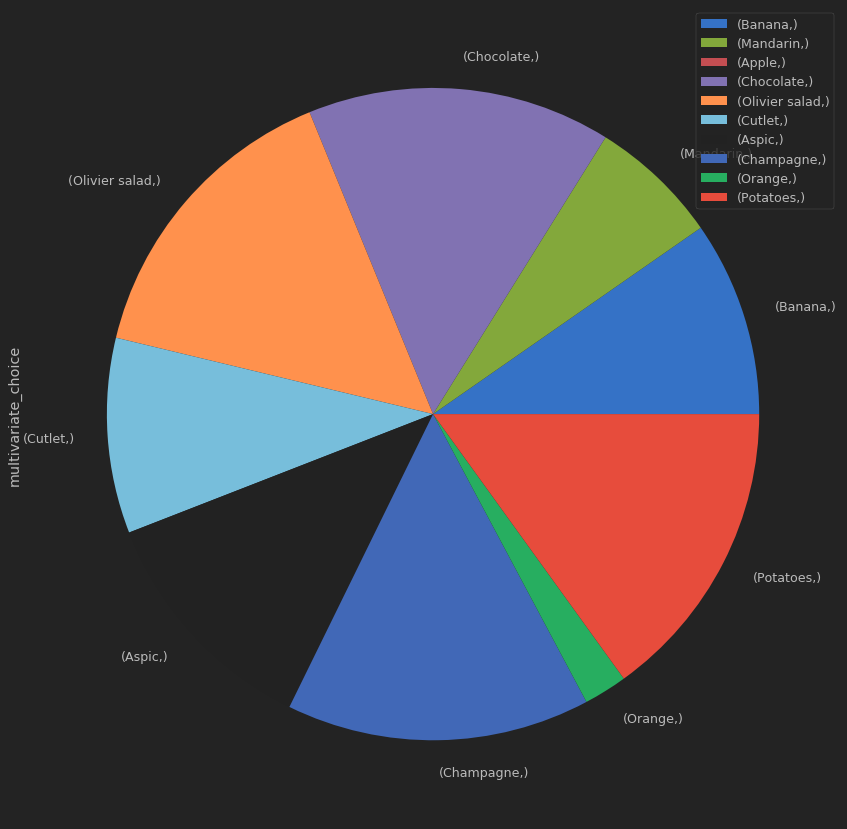

In [46]:
df.plot.pie(y="multivariate_choice",figsize=(15, 15))